### iris regression + 학습 진행 모니터링
- data: '../../EX_ML/data/iris.csv'
- feature: sapal.lenth, sapal.width, petal.length
- label: petal.width
---
- 모니터링
    - 기준: validation data의 loss & score
    - 평가: loss와 score를 비교해서 학습 중단 여부를 결정
    - 선택: 현재까지 진행된 모델의 parameter(weight, bais) 저장 여부 또는 모델 전체 저장 여부

- Regression model base on DNN
---
- dataset: '../../EX_ML/data/iris.csv
- feature: sepal.length, sepal.width, petal.length
- label: petal.width
- learning method: superviesd learning, regression
- learning algorithm: ANN
- frame work: Pytorch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optima
from torch.utils.data import Dataset, DataLoader

from torchmetrics.regression import R2Score
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# random_state: 16
torch.manual_seed(16)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print('-- Notice --')
print(f'decvice: {DEVICE}')
print(f'torch ver: {torch.__version__}')
print(f'pandas ver: {pd.__version__}')
print(f'numpy ver: {np.__version__}')

-- Notice --
decvice: cpu
torch ver: 2.4.1
pandas ver: 2.0.3
numpy ver: 1.24.3


In [3]:
FILE_PATH = '../../EX_ML/data/iris.csv'

iris_df = pd.read_csv(FILE_PATH, usecols=['sepal.length', 'sepal.width', 'petal.length', 'petal.width'])
iris_df.head()

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


- model class
---
- `class perpose: iris data learning & regression`
- class name: IrisRegModel
- parents class: nn.Module
- parameter: None
- attiribute field: undetermind
- class function: create model structure, forward learning model
- `class structure`
    - input layer: input 3, output 20, activation function: sigmoid or ReLU or LeakyReLU
    - hidden layer: input 20, output 10, activation function: sigmoid or ReLU or LeakyReLU
    - output layer: input 10, output 1, activation function: None

In [4]:
class IrisRegModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # functional method
        self.input_layer = nn.Linear(3, 20)
        self.hidden_layer = nn.Linear(20, 10)
        self.output_layer = nn.Linear(10, 1)
        
        # class method
        # self.input_layer = nn.Sequential(nn.Linear(3, 20),
        #                                 nn.ReLU())
        # self.hidden_layer = nn.Sequential(nn.Linear(20, 10),
        #                                   nn.ReLU())
        
    
    def forward(self, X):
        
        # functional method
        y = F.relu(self.input_layer(X))
        y = F.relu(self.hidden_layer(y))
        y = self.output_layer(y)
        
        # class method
        # y = self.input_layer(X)
        # y = self.hidden_layer(y)
        # y = self.output_layer(y)
        
        return y

In [5]:
model_class_test = IrisRegModel()

print(model_class_test, end='\n\n')
summary(model_class_test, input_size=(150, 3))

IrisRegModel(
  (input_layer): Linear(in_features=3, out_features=20, bias=True)
  (hidden_layer): Linear(in_features=20, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)



Layer (type:depth-idx)                   Output Shape              Param #
IrisRegModel                             [150, 1]                  --
├─Linear: 1-1                            [150, 20]                 80
├─Linear: 1-2                            [150, 10]                 210
├─Linear: 1-3                            [150, 1]                  11
Total params: 301
Trainable params: 301
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.04

- dataset class
---
- dataset: '../../EX_ML/data/iris.csv'
- parents class: torch.utils.data.Dataset
- `class name: IrisDataset`
- feature: sepal.length, sepal.width, petal.lenrth
- label: petal.width
- parameter: data_df
- attirbute flied: feature_df, label_df, X_train_df, X_val_ts, y_train_df, y_val_ts, n_rows, features, n_features, labels, n_labels
- class function: create dataset structure, length dataset, get dataset batch size
- `class structure`
    - __ init __(self)
    - __ len __(self)
    - __ getitem __(self)

In [6]:
class IrisDataSet(Dataset):
    def __init__(self, data_df):
        super().__init__()
        self.data_df = data_df

        self.feature_df = self.data_df[data_df.columns[:-1]]
        self.label_df = self.data_df[[data_df.columns[3]]]
        
        # random_state: 16
        # train : val = 8 : 2
        X_train, X_val, y_train, y_val = train_test_split(self.feature_df, self.label_df, random_state=16, test_size=0.2)
        scaler = StandardScaler()
        scaler.fit(X_train, y_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)
        
        self.X_train_df = X_train
        self.X_val_ts = torch.FloatTensor(X_val)
        self.y_train_df = y_train
        self.y_val_ts = torch.FloatTensor(y_val.values)
        
        self.n_rows = self.X_train_df.shape[0]
        self.features = self.feature_df.columns
        self.n_features = self.feature_df.shape[1]
        self.labels = self.data_df.iloc[:, 0].unique()
        self.n_labels = len(self.labels)
        
    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, idx):
        
        X_train_ts = torch.FloatTensor(self.X_train_df[idx])
        y_train_ts = torch.FloatTensor(self.y_train_df.iloc[idx].values)
        
        return X_train_ts, y_train_ts      

In [7]:
iris_test_dataset = IrisDataSet(iris_df)

In [8]:
iris_test_dataset.features, iris_test_dataset.n_features, iris_test_dataset.labels, iris_test_dataset.n_labels, iris_test_dataset.n_rows

(Index(['sepal.length', 'sepal.width', 'petal.length'], dtype='object'),
 3,
 array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.4, 4.8, 4.3, 5.8, 5.7, 5.2, 5.5,
        4.5, 5.3, 7. , 6.4, 6.9, 6.5, 6.3, 6.6, 5.9, 6. , 6.1, 5.6, 6.7,
        6.2, 6.8, 7.1, 7.6, 7.3, 7.2, 7.7, 7.4, 7.9]),
 35,
 120)

- prepare learning model
---
- learning count: EPOCHS 100
- learning rate: lr [0.001, 0.01, 0.1]
- batch size: BATCH_SIZE [16, 32, 64]
- data location: DEVICE

- validation & test function
---
- function name: testing
- parameter: model, x, y
- function return: loss, score
- `must not update weight & bais`

In [9]:
def testing(model, X_ts, y_ts):
    with torch.no_grad():
        
        pred = model(X_ts)
        
        loss = F.mse_loss(pred, y_ts)
        
        score = R2Score()(pred, y_ts)
    
    return loss, score

- model learning
---
- function name: training
- parameter: model, epochs, lr, batch_size, dataset
- function return: loss, score

In [10]:
def tarining_1(dataset, model, epochs, lr, batch):
    train_val_loss = {'train':[], 'val':[]}
    train_val_score = {'train':[], 'val':[]}
    optmizer = optima.Adam(model.parameters(), lr=lr)
    data_dl = DataLoader(dataset, batch_size=batch)
    
    for epoch in range(1, epochs+1):
        total_train_loss, total_train_score = 0, 0
        
        # 학습 모드로 모델 설정
        model.train()
        
        for X_train, y_train in data_dl:
            batch_cnt = dataset.n_rows / batch
            
            pred = model(X_train)
            
            loss = F.mse_loss(pred, y_train)
            total_train_loss += loss
            
            score = R2Score()(pred, y_train)
            total_train_score += score
            
            optmizer.zero_grad()
            loss.backward()
            optmizer.step()
        
        # 모델 검증 모드 설정
        model.eval()
        
        X_val, y_val = dataset.X_val_ts, dataset.y_val_ts
        
        with torch.no_grad():
        
            pred_val = model(X_val)
            
            loss_val = F.mse_loss(pred_val, y_val)
            
            score_val = R2Score()(pred_val, y_val)
        
        
        loss_train = (total_train_loss/batch_cnt).item()
        score_train = (total_train_score/batch_cnt).item()
        
        train_val_loss['train'].append(loss_train)
        train_val_score['train'].append(score_train)
        train_val_loss['val'].append(loss_val.item())
        train_val_score['val'].append(score_val.item())
        
        if epoch%5 == 0:
            print(f"[{epoch:5}/{epochs:5}]  [Train]      loss: {loss_train:.6f}, score: {score_train:.6f}")
            print(f"[{epoch:5}/{epochs:5}]  [Validation] loss: {loss_val.item():.6f}, score: {score_val.item():.6f}\n")
    
    return train_val_loss, train_val_score

In [20]:
def tarining(dataset, model, epochs, lr, batch, threshold):
    train_val_loss = {'train':[], 'val':[]}
    train_val_score = {'train':[], 'val':[]}
    optmizer = optima.Adam(model.parameters(), lr=lr)
    data_dl = DataLoader(dataset, batch_size=batch)
    
    # learning 모니터링/스케쥴링 
    # train_val_loss, train_val_score 활용
    # 임계기준: 10번
    break_cnt = 0
    
    for epoch in range(1, epochs+1):
        total_train_loss, total_train_score = 0, 0
        
        for X_train, y_train in data_dl:
            batch_cnt = dataset.n_rows / batch
            
            pred = model(X_train)
            
            loss = F.mse_loss(pred, y_train)
            total_train_loss += loss
            
            score = R2Score()(pred, y_train)
            total_train_score += score
            
            optmizer.zero_grad()
            loss.backward()
            optmizer.step()

        X_val, y_val = dataset.X_val_ts, dataset.y_val_ts
        val_loss, val_score = testing(model, X_val, y_val)
        
        
        loss_train = (total_train_loss/batch_cnt).item()
        score_train = (total_train_score/batch_cnt).item()
        
        train_val_loss['train'].append(loss_train)
        train_val_score['train'].append(score_train)
        train_val_loss['val'].append(val_loss.item())
        train_val_score['val'].append(val_score.item())
        
        if epoch%5 == 0:
            print(f"[{epoch:5}/{epochs:5}]  [Train] loss: {loss_train:.6f}, score: {score_train:.6f}")
            print(f"[{epoch:5}/{epochs:5}]  [Test]  loss: {val_loss.item():.6f}, score: {val_score.item():.6f}\n")
        
        
        # 학습 진행 모니터링/스케쥴링
        # loss value
        if len(train_val_loss['val']) >= 2:
            if train_val_loss['val'][-1] >= train_val_loss['val'][-2]:
                break_cnt += 1
                
        # # score value
        # if len(train_val_score['val']) >= 2:
        #     if train_val_score['val'][-1] >= total_train_score['val'][-2]:
        #         break_cnt += 1
        
        # 학습 중단 여부 설정
        if break_cnt > threshold:
            print("성능 및 손실의 개선이 없어서 학습을 중단합니다.\n")
            print(f"[{epoch:5}/{epochs:5}]  [Train] loss: {loss_train:.6f}, score: {score_train:.6f}")
            print(f"[{epoch:5}/{epochs:5}]  [Test]  loss: {val_loss.item():.6f}, score: {val_score.item():.6f}\n")
            break
        
        
    
    return train_val_loss, train_val_score

In [25]:
iris_ds = IrisDataSet(iris_df)
iris_reg_model = IrisRegModel()

# print(iris_reg_model)
# summary(iris_reg_model, input_size=(120, 3))

In [26]:
# dataset, model, epochs, lr, batch
# dataset: iris_ds
# model: iris_reg_model
# epochs: 10
# learning rate: 0.01
# batch: 10

loss_dict, score_dict = tarining(iris_ds, iris_reg_model, 50, 0.01, 10, 3)

[    5/   50]  [Train] loss: 0.039829, score: 0.924020
[    5/   50]  [Test]  loss: 0.053170, score: 0.898420

[   10/   50]  [Train] loss: 0.031146, score: 0.940317
[   10/   50]  [Test]  loss: 0.038932, score: 0.925623

성능 및 손실의 개선이 없어서 학습을 중단합니다.

[   12/   50]  [Train] loss: 0.030066, score: 0.942414
[   12/   50]  [Test]  loss: 0.039398, score: 0.924732



In [27]:
def draw_two_plot(loss, r2, title):
    
    # 축을 2개 사용하고 싶음.
    fig, ax1 = plt.subplots(figsize=(7, 7))
    ax2 = ax1.twinx()
    
    ax1.plot(loss['train'], label=f"train loss mean: {sum(loss['train'])/len(loss['train']):.6f}", color='#5587ED')
    ax1.plot(loss['val'], label=f"test loss mean: {sum(loss['val'])/len(loss['val']):.6f}", color='#F361A6')
    ax2.plot(r2['train'], label=f"train score max: {max(r2['train'])*100:.2f} %", color='#00007F')
    ax2.plot(r2['val'], label=f"test score max: {max(r2['val'])*100:.2f} %", color='#99004C')
    
    fig.suptitle(f'{title} iris ANN regression', fontsize=15)
    ax1.set_ylabel('loss', fontsize=10, color='#5587ED')
    ax2.set_ylabel('score', fontsize=10, color='#00007F')
    
    fig.legend(loc='center')
    plt.show()

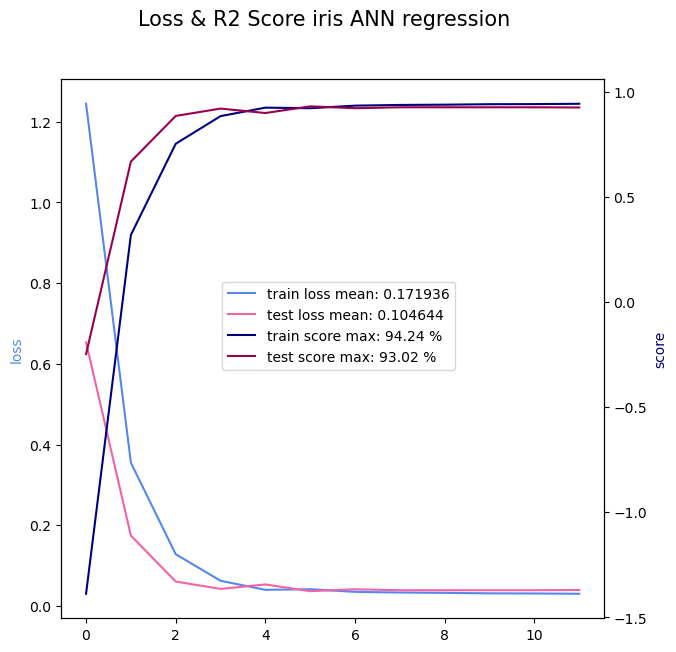

In [28]:
draw_two_plot(loss_dict, score_dict, 'Loss & R2 Score')

- model save method
---
1. model's parameters save
2. model save

In [29]:
# 학습된 모델 파라미터 값 확인
iris_reg_model.state_dict()

OrderedDict([('input_layer.weight',
              tensor([[-0.2076, -0.0576,  0.6489],
                      [ 0.3864,  0.5173, -0.2832],
                      [-0.2568, -0.3670, -0.7098],
                      [ 0.4835, -0.4088,  0.0120],
                      [-0.4128,  0.3728,  0.6063],
                      [ 0.1047, -0.0719, -0.1817],
                      [-0.4756,  0.1493, -0.1435],
                      [-0.0158, -0.1793, -0.5972],
                      [ 0.4337, -0.2857, -0.3318],
                      [ 0.2106, -0.4085, -0.2347],
                      [ 0.1326,  0.3549,  0.4522],
                      [-0.5606,  0.2175,  0.6042],
                      [ 0.4009,  0.3770,  0.4152],
                      [-0.3817, -0.1505,  0.7937],
                      [-0.6274,  0.5398, -0.4665],
                      [ 0.4355,  0.5287, -0.2610],
                      [-0.4827,  0.2217, -0.2076],
                      [-0.3867,  0.1798,  0.3429],
                      [-0.5432, -0.2759,  0.51

In [30]:
import os
save_path = '../model/iris/'

In [37]:
# 층별 모델 가중치와 바이어스 저장
save_file = '../model/iris/iris_regression_parameter.pth'

In [36]:
# 파일 경로가 없으면 폴더 만듦
if not os.path.exists(save_path):
    os.makedirs(save_path)  # 하위 폴더 까지 생성.. 그래서 쭉 적을 필요는 없었..

In [38]:
torch.save(iris_reg_model.state_dict(), save_file)

In [39]:
torch.save(iris_reg_model.state_dict(), save_path+'iris_regression_parameter.csv')

In [44]:
# 가중치와 바이어스 로딩

wb_ts = torch.load(save_file, weights_only=False)
print(type(wb_ts))

<class 'collections.OrderedDict'>


In [45]:
# model instance save
model = IrisRegModel()
model.load_state_dict(wb_ts)

<All keys matched successfully>

In [46]:
loss_dict, score_dict = tarining(iris_ds, model, 50, 0.01, 10, 3)

[    5/   50]  [Train] loss: 0.028861, score: 0.944526
[    5/   50]  [Test]  loss: 0.042804, score: 0.918225

성능 및 손실의 개선이 없어서 학습을 중단합니다.

[    8/   50]  [Train] loss: 0.027371, score: 0.947603
[    8/   50]  [Test]  loss: 0.048184, score: 0.907946



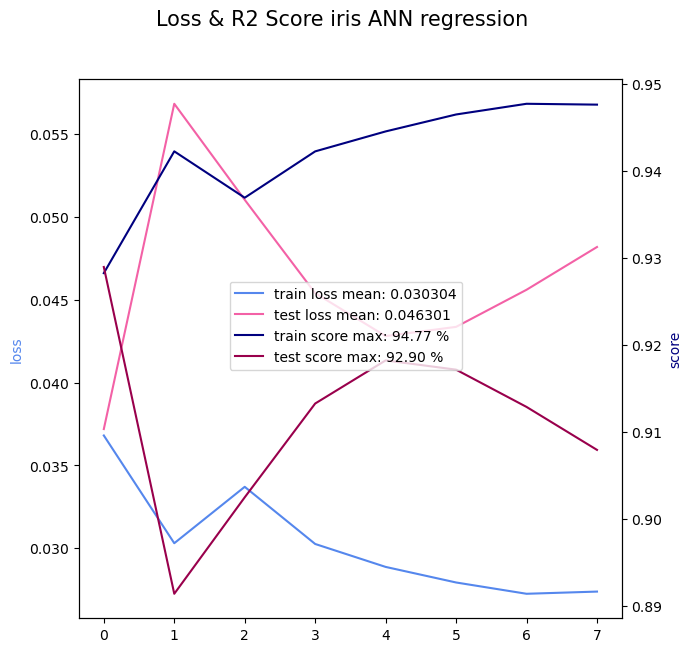

In [47]:
# over-fitting...
draw_two_plot(loss_dict, score_dict, 'Loss & R2 Score')